# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 22: Random Forest Classification and Regression

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

import collections

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

Today we will introduce an idea even more powerful than the Decision Tree model to solve classification and regression problems: the **Random Forest** model. In order to understand Random Forests we will introduce some important theoretical concepts: *Bootstrap aggregating* (a.k.a. *Bagging*), *Out-of-bag (OOB)* error, and *Feature Bagging* (a.k.a. the *random subspace method* or *attribute bagging*). We will see how these approaches in Machine Learning prevent overfitting in the training of a complex model like Random Forest.

## 1. Random Forest Classification

For Random Forest Classification we use `RandomForestClassifier` from `scikit-learn`. But first, let's look at the data we are going to fit our model on.

In [2]:
df = pd.read_csv(os.path.join(data_dir, 'HR_comma_sep.csv'))
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


The task is to predict the value of `left` variable - whether the employee has left the company or not - from a set of predictors encompassing the following:

 - `satisfaction_level`: a measure of employee’s level of satisfaction
 - `last_evaluation`: the result of a last evaluation
 - `number_projects`: in how many projects did the employee took part
 - `average_monthly_hours`: how working hours monthly on average
 - `time_spend_company`: for how long is the employee with us
 - `Work_accident`: any work accidents?
 - `promotion_last_5years`: did the promotion occur in the last five years?
 - `sales`: department (sales, accounting, hr, technical, support, management, IT, product_mng, marketing, RandD)
 - `salary`: salary class (low, medium, high)


### Random Forests: the Algorithm

There are three important concepts to understand how Random Forest builds upon Decision Trees:

 - **Bootstrap aggregating (Bagging).** We begin with some training set for our model, $D$. Bagging generates $m$ new training sets, $D_i,\ i=1, 2, \ldots, m$, by randomly sampling from $D$, uniformly and *with replacement*. The samples obtained in this way are known as *bootstrap samples*. In Random Forests, $m$ simpler models - Decision Trees, precisely - are fitted for each $D_i$ bootstrap sample. 
 
 
 - **Out-of-bag (OOB) error.** Each time a new bootstrap sample $D_i$ is produced, some data points remain *out of the bag*, are not used in model training, and form the **OOB set** (the *Out-of-bag set*). The OOB error is a *prediction error* which is computed from the OOB set, where the prediction is obtained by averaging the response (in regression) or as a majority vote (in classification) from all the trees in the forest that were not trained on that particular OOB instance.
 
 
 - **The Random Subspace Method (Feature Bagging).** The Random Subspace Method is a method to control for the complexity of the decision trees grown in a Random Forest model. **On each new split**, only a randomly chosen *subset of predictors* is used to find the optimal split. The Random Forests algorithm, as we will see, has a control parameter that determines how many features are randomly selected to produce a new split.

![](rand_forest.jpg)

***

In [3]:
# encoding 'salary' categorical variable

df['salary'] = pd.Categorical(df['salary'], categories=['low', 'medium', 'high'], ordered=True)
df['salary'] = df['salary'].cat.codes

In [4]:
# encoding 'sales' categorical variable

df['sales'] = pd.Categorical(df['sales'])
df['sales'] = df['sales'].cat.codes

In [5]:
# feature matrix
X = df.drop(columns = 'left')

# target vector
y = df['left']

We now perform 5-fold cross validation for a set of Random Forests across the following control parameters:

- `n_estimators`: the number of trees to grow
- `max_features`: the number of variables to randomly sample as candidates at each split (to control Feature Bagging).


We will take the model with the highest ROC-AUC score, and then do a final (re)fit on that model.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# defining grid of parameters
param_grid = {
    'n_estimators':np.arange(250, 1250, 250),
    'max_features':np.arange(3, df.shape[1])
}

rf = RandomForestClassifier(random_state=1023)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1,
                          scoring=['accuracy', 'recall', 'f1', 'roc_auc'],
                          refit='roc_auc')

In [7]:
# iterating through the grid of parameters by using 5-fold CV
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1023),
             n_jobs=-1,
             param_grid={'max_features': array([3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 250,  500,  750, 1000])},
             refit='roc_auc', scoring=['accuracy', 'recall', 'f1', 'roc_auc'])

In [9]:
# the highest ROC-AUC score
grid_search.best_score_

0.9940062397252655

In [10]:
# optimal parameters
grid_search.best_params_

{'max_features': 4, 'n_estimators': 1000}

In [11]:
# results from each parameter choice and every fold from parameter grid
grid_search.cv_results_

{'mean_fit_time': array([ 3.50263448,  7.33124013, 11.17665834, 15.39973259,  4.24626284,
         8.85991054, 13.43102689, 18.28441887,  5.08824983, 10.40177264,
        15.54358172, 21.80931768,  6.89690156, 12.03841815, 18.37791533,
        24.61839614,  6.87830353, 13.72554445, 20.55893564, 27.58181424,
         7.76964364, 15.42040401, 26.49029632, 36.03563032,  9.94107699,
        17.88557005, 28.27261162, 38.12976317]),
 'std_fit_time': array([0.0661168 , 0.1927338 , 0.53481377, 0.5826409 , 0.13786487,
        0.17161791, 0.80735572, 0.46403022, 0.1114165 , 0.21031193,
        0.40969776, 1.39961345, 0.66005728, 0.39245593, 0.46621784,
        0.59393496, 0.31729709, 0.31065413, 0.59032384, 0.75400619,
        0.32912157, 0.47342223, 1.76258002, 0.84673559, 0.59240101,
        0.48152405, 3.24993616, 4.9019738 ]),
 'mean_score_time': array([0.35108552, 0.78121114, 1.18978105, 1.35044875, 0.35182581,
        0.67451491, 1.0575417 , 1.38768129, 0.36432958, 0.66199751,
        1.05

Let's get a better view of the cross-validation results:

In [12]:
results = pd.DataFrame(columns = ['roc-auc', 'accuracy', 'recall', 'f1', 'max_features', 'n_trees'])

results['roc-auc'] = grid_search.cv_results_['mean_test_roc_auc']
results['accuracy'] = grid_search.cv_results_['mean_test_accuracy']
results['recall'] = grid_search.cv_results_['mean_test_recall']
results['f1'] = grid_search.cv_results_['mean_test_f1']
results['max_features'] = grid_search.cv_results_['param_max_features']
results['n_trees'] = grid_search.cv_results_['param_n_estimators']

results

,roc-auc,accuracy,recall,f1,max_features,n_trees
0,0.993897,0.991733,0.975070,0.982263,3,250
1,0.993730,0.991933,0.975350,0.982692,3,500
2,0.993794,0.991866,0.975070,0.982542,3,750
3,0.993817,0.992000,0.975350,0.982829,3,1000
4,0.993776,0.992066,0.976751,0.983018,4,250
5,0.993742,0.991866,0.976190,0.982581,4,500
6,0.993956,0.992000,0.976471,0.982867,4,750
7,0.994006,0.992066,0.976471,0.983006,4,1000
8,0.993545,0.991666,0.976190,0.982168,5,250
9,0.993655,0.991666,0.976190,0.982168,5,500


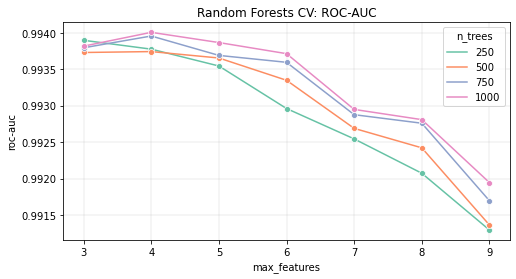

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))


sns.lineplot(ax=ax, data=results, x='max_features', y='roc-auc', hue='n_trees', palette='Set2', marker='o')
plt.grid(linewidth=.25)
plt.title('Random Forests CV: ROC-AUC');

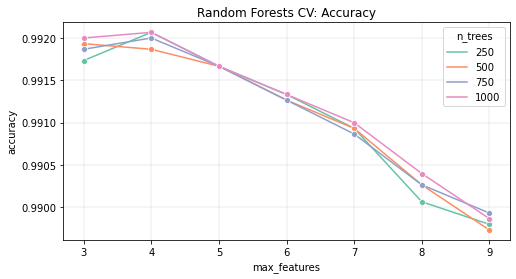

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))


sns.lineplot(ax=ax, data=results, x='max_features', y='accuracy', hue='n_trees', palette='Set2', marker='o')
plt.grid(linewidth=.25)
plt.title('Random Forests CV: Accuracy');

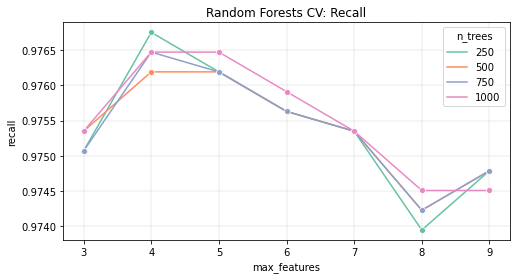

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))


sns.lineplot(ax=ax, data=results, x='max_features', y='recall', hue='n_trees', palette='Set2', marker='o')
plt.grid(linewidth=.25)
plt.title('Random Forests CV: Recall');

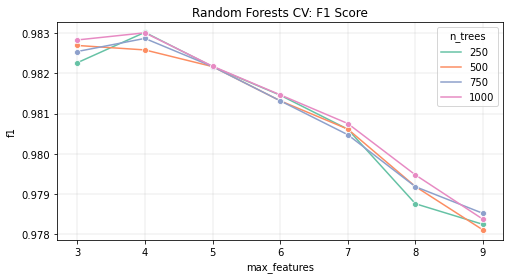

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))


sns.lineplot(ax=ax, data=results, x='max_features', y='f1', hue='n_trees', palette='Set2', marker='o')
plt.grid(linewidth=.25)
plt.title('Random Forests CV: F1 Score');

In [17]:
# OOB score from the most optimal RF Classifier
rf_class_opt = RandomForestClassifier(oob_score=True, **grid_search.best_params_, random_state=1023, n_jobs=-1)
rf_class_opt.fit(X, y)
1 - rf_class_opt.oob_score_

0.0068671244749649585

Can we actually do more with less trees?

In [18]:
# fitting RF Classifiers for fixed number of max_features, while varying number of trees, up to 250

oob_errors = []

for n_trees in range(1, 251):
    rfc = RandomForestClassifier(n_estimators=n_trees, max_features=4, oob_score=True,  random_state=1023, n_jobs=-1)
    rfc.fit(X, y)
    oob_errors.append(1 - rfc.oob_score_)
    
oob_errors = np.array(oob_errors)

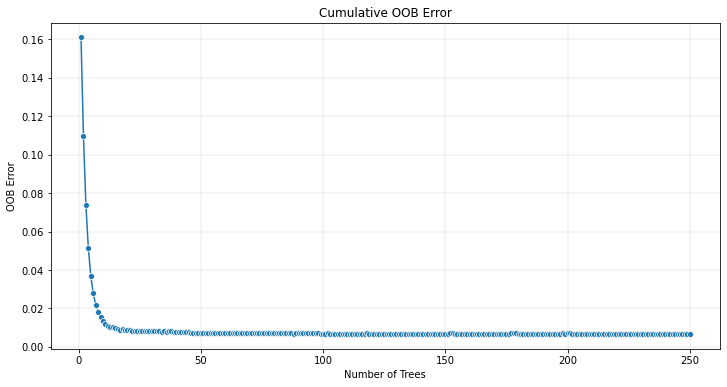

In [19]:
# visualizing OBB errors for various forest sizes

fig, ax = plt.subplots(figsize=(12, 6))


sns.lineplot(ax=ax, x=np.arange(1, len(oob_errors)+1), y=oob_errors, marker='o')
plt.grid(linewidth=.25)
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.title('Cumulative OOB Error');

The optimal number of trees (for up to 250) is:

In [20]:
np.array(oob_errors).argmin()

145

In [21]:
oob_errors[146]

0.0068004533635576125

With even less OOB error! So not only can we have much faster model with significantly less trees, but we also get more robust model. Let's now fit this model. 

In [22]:
rfc_redux = RandomForestClassifier(n_estimators=146, max_features=3, oob_score=True, random_state=1023, n_jobs=-1)
rfc_redux.fit(X, y)

RandomForestClassifier(max_features=3, n_estimators=146, n_jobs=-1,
                       oob_score=True, random_state=1023)

In [23]:
# checking some metrics for this model 
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [24]:
recall_score(y, rfc_redux.predict(X))

1.0

In [25]:
f1_score(y, rfc_redux.predict(X))

1.0

In [26]:
roc_auc_score(y, rfc_redux.predict(X))

1.0

In [27]:
# calculating importance scores

pd.DataFrame(zip(rfc_redux.feature_names_in_, rfc_redux.feature_importances_), columns=['Feature', 'Feature Importance'])

,Feature,Feature Importance
0,satisfaction_level,0.344227
1,last_evaluation,0.126451
2,number_project,0.177128
3,average_montly_hours,0.138312
4,time_spend_company,0.185796
5,Work_accident,0.006434
6,promotion_last_5years,0.000897
7,sales,0.012098
8,salary,0.008657


## 2. Random Forest Regression

For Random Forest Regression we use `RandomForestRegressor` from `scikit-learn`; but, data first. We use `Boston Housing` for this section which can be found [here](https://github.com/selva86/datasets/blob/master/BostonHousing.csv).

In [28]:
df = pd.read_csv(os.path.join(data_dir, 'BostonHousing.csv'), sep=',')
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


Here are the variables:

- `crim`: per capita crime rate by town
- `zn`: proportion of residential land zoned for lots over 25,000 sq.ft.
- `indus`: proportion of non-retail business acres per town.
- `chas`: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- `nox`: nitric oxides concentration (parts per 10 million)
- `rm`: average number of rooms per dwelling
- `age`: proportion of owner-occupied units built prior to 1940
- `dis`: weighted distances to five Boston employment centers
- `rad`: index of accessibility to radial highways
- `tax`: full-value property-tax rate per \$10,000
- `ptratio`: pupil-teacher ratio by town
- `b`: $1000(B_k - 0.63)^2$ where $B_k$ is the proportion of blacks by town
- `lstat`: % lower status of the population
- `medv`: Median value of owner-occupied homes in $1000’s

The `medv` variable is the outcome.

In [29]:
df = df.drop(columns='b')

In [30]:
# feature matrix 
X = df.drop(columns='medv')

# target variable
y = df['medv']

In [31]:
# fitting RFR
from sklearn.ensemble import RandomForestRegressor


rf_reg = RandomForestRegressor(n_estimators=1000, max_features=7, criterion='squared_error', random_state=1023, n_jobs=-1)

rf_reg.fit(X, y)

RandomForestRegressor(max_features=7, n_estimators=1000, n_jobs=-1,
                      random_state=1023)

In [32]:
# checking some model metrics

rf_reg.score(X, y)

0.984586232013264

In [33]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, rf_reg.predict(X))

1.3012234521343624

Again - can we do more for less? We fit RFRs with smaller number of trees, up to 250.

In [34]:
mse = []
for n in range(1, 251):
    rfr = RandomForestRegressor(n_estimators=n, max_features=7, random_state=1023, n_jobs=-1)
    rfr.fit(X, y)
    mse.append(mean_squared_error(y, rfr.predict(X)))
    
mse = np.array(mse)

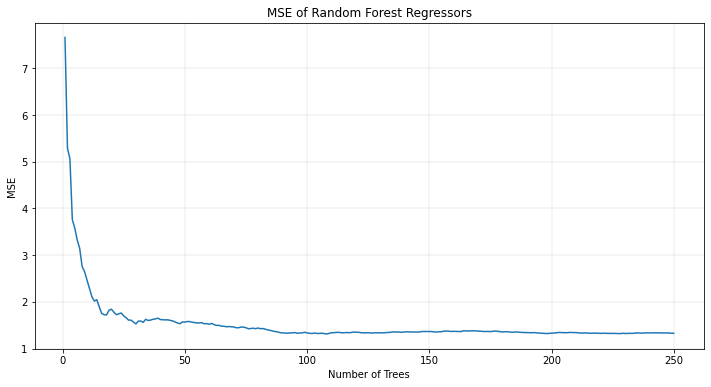

In [35]:
# visualizing MSE for various forest sizes
fig, ax = plt.subplots(figsize=(12, 6))


sns.lineplot(ax=ax, x=np.arange(1, len(mse)+1), y=mse)
plt.grid(linewidth=.25)
plt.xlabel('Number of Trees')
plt.ylabel('MSE')
plt.title('MSE of Random Forest Regressors');

In [36]:
# and the winner is...
mse.argmin()

107

In [37]:
mse[108]

1.3247833139769105

In [38]:
# fitting the smaller model

rfr_redux = RandomForestRegressor(n_estimators=108, max_features=7, random_state=1023, n_jobs=-1)
rfr_redux.fit(X, y)

RandomForestRegressor(max_features=7, n_estimators=108, n_jobs=-1,
                      random_state=1023)

In [39]:
rfr_redux.score(X, y)

0.9844493754334269

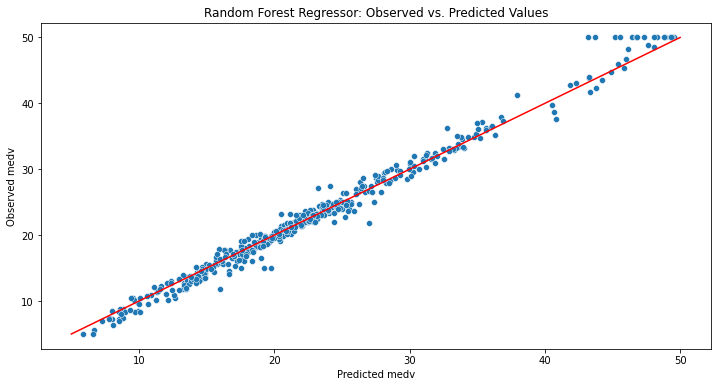

In [40]:
# visualizing MSE for various forest sizes

fig, ax = plt.subplots(figsize=(12, 6))


sns.scatterplot(ax=ax, x=rfr_redux.predict(X), y=y)
ax.plot(np.arange(y.min(), y.max() + 1), np.arange(y.min(), y.max() + 1), 'r')
plt.xlabel('Predicted medv')
plt.ylabel('Observed medv')
plt.title('Random Forest Regressor: Observed vs. Predicted Values');

### Further Reading

[Bagging (Bootstrap Aggregation), from Corporate Finance Institute](https://corporatefinanceinstitute.com/resources/data-science/bagging-bootstrap-aggregation/)

[Understanding Random Forest: How the Algorithm Works and Why it Is So Effective, Tony Yiu, Towards Data Science, Medium](https://towardsdatascience.com/understanding-random-forest-58381e0602d2#_=_)

***

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>